In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
import seaborn as sns

# Read dataset from csv
df = pd.read_csv('/content/drive/MyDrive/dataset/bank-full.csv', \

# Data Cleaning
if df.isnull().sum().sum() > 0:
    df = df.dropna()
df = df.drop_duplicates()

# Split the data
X = df.drop(columns=['y'])
y = df['y']

# Initialize LabelEncoder
label_encoder = LabelEncoder()
X_encoded = X.copy()
for column in X.columns:
    if X[column].dtype == 'object':
        X_encoded[column] = label_encoder.fit_transform(X[column])

# RFE with RandomForestClassifier
model = RandomForestClassifier(random_state=42)
rfe = RFE(model, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_encoded, y)

# Get the selected features
selected_features = X_encoded.columns[rfe.support_]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Initialize the classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "k-Nearest Neighbors": KNeighborsClassifier()
}

# Train and evaluate each classifier with RFE selected features
print("Accuracy with RFE selected features")
results_rfe_selected = {}
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results_rfe_selected[clf_name] = accuracy
    print(f"{clf_name}:", accuracy)

Accuracy with RFE selected features
Logistic Regression: 0.8854362490324007
Support Vector Machine: 0.8794647793873714
k-Nearest Neighbors: 0.8762578790224483


<ipython-input-10-c1049c65fd74>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')


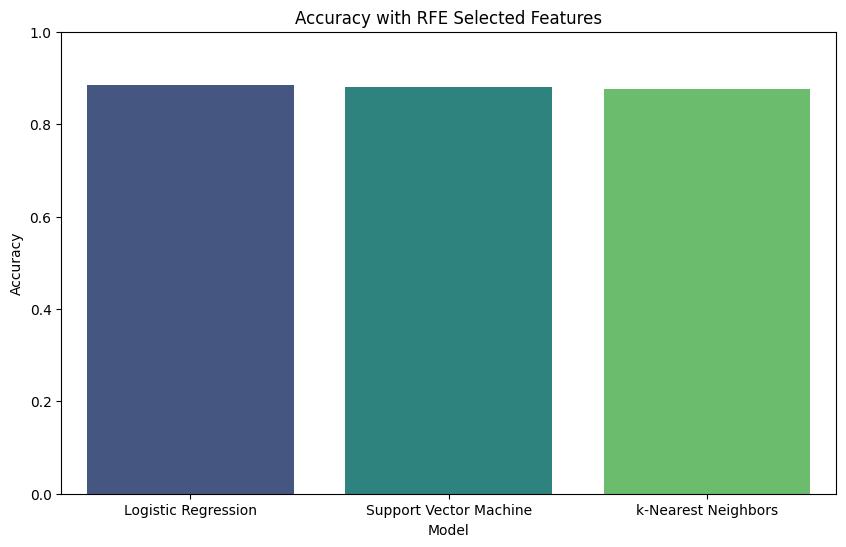

In [ ]:
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results_rfe_selected.items(), columns=['Model', 'Accuracy'])

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy with RFE Selected Features')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for accuracy
plt.show()

In [ ]:
# Get the feature names
all_feature_names = X_encoded.columns  # Ensure this matches the features used in RFE
eliminated_features = all_feature_names[~rfe.support_]
selected_features = all_feature_names[rfe.support_]

print("\nEliminated Features:")
print(eliminated_features)

print("\nSelected Features:")
print(selected_features)


Eliminated Features:
Index(['marital', 'default', 'housing', 'loan', 'contact', 'previous'], dtype='object')

Selected Features:
Index(['age', 'job', 'education', 'balance', 'day', 'month', 'duration',
       'campaign', 'pdays', 'poutcome'],
      dtype='object')


In [ ]:
# Find the highest performing model
best_model = max(results_rfe_selected, key=results_rfe_selected.get)
print("Best Model:", best_model)

# Train and evaluate the highest performing model with RFE-selected features
best_model_classifier = classifiers[best_model]
best_model_classifier.fit(X_train, y_train)
y_pred_best_model = best_model_classifier.predict(X_test)
accuracy_best_model = accuracy_score(y_test, y_pred_best_model)
print("Accuracy of Best Model:", accuracy_best_model)

# Apply ensemble techniques to the highest performing model
# Stacking Classifier
from sklearn.ensemble import StackingClassifier
estimators = [('rf', RandomForestClassifier(random_state=42)),
              ('svc', SVC(random_state=42)),
              ('knn', KNeighborsClassifier())]
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_classifier.fit(X_train, y_train)
y_pred_stacking = stacking_classifier.predict(X_test)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print("Accuracy of Stacking Classifier:", accuracy_stacking)

# AdaBoost Classifier
from sklearn.ensemble import AdaBoostClassifier
adaboost_classifier = AdaBoostClassifier(base_estimator=best_model_classifier, random_state=42)
adaboost_classifier.fit(X_train, y_train)
y_pred_adaboost = adaboost_classifier.predict(X_test)
accuracy_adaboost = accuracy_score(y_test, y_pred_adaboost)
print("Accuracy of AdaBoost Classifier:", accuracy_adaboost)

# Bagging Classifier
from sklearn.ensemble import BaggingClassifier
bagging_classifier = BaggingClassifier(base_estimator=best_model_classifier, random_state=42)
bagging_classifier.fit(X_train, y_train)
y_pred_bagging = bagging_classifier.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
print("Accuracy of Bagging Classifier:", accuracy_bagging)


Best Model: Logistic Regression
Accuracy of Best Model: 0.8854362490324007
Accuracy of Stacking Classifier: 0.9019130819418335


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of AdaBoost Classifier: 0.8821187658962734


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy of Bagging Classifier: 0.8845515868627668


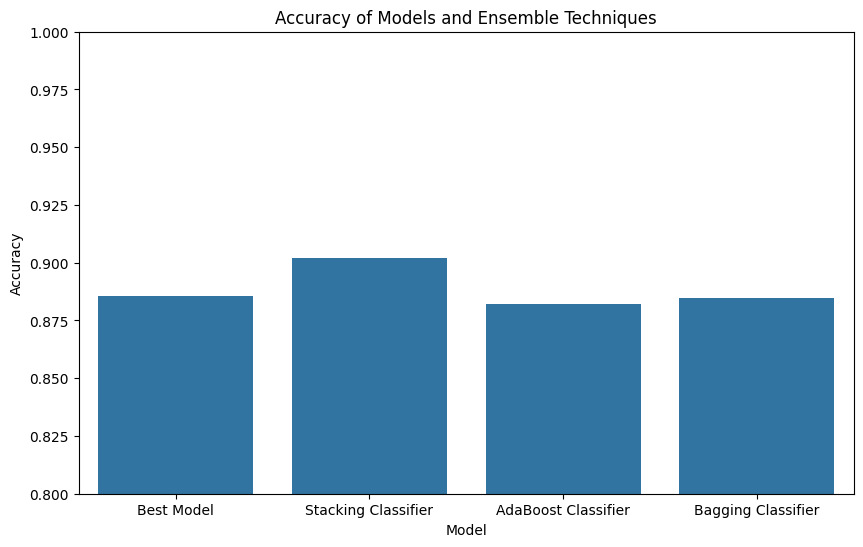

In [ ]:
# Create a dictionary to store accuracies
ensemble_accuracies = {
    "Best Model": accuracy_best_model,
    "Stacking Classifier": accuracy_stacking,
    "AdaBoost Classifier": accuracy_adaboost,
    "Bagging Classifier": accuracy_bagging
}

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=list(ensemble_accuracies.keys()), y=list(ensemble_accuracies.values()))
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Models and Ensemble Techniques')
plt.ylim(0.8, 1.0)
plt.show()

In [ ]:
# Print summary of accuracies
print("\nSummary of Ensemble Model Accuracies")
for model, accuracy in ensemble_accuracies.items():
    print(f"{model}: {accuracy:.4f}")


Summary of Ensemble Model Accuracies
Best Model: 0.8854
Stacking Classifier: 0.9019
AdaBoost Classifier: 0.8821
Bagging Classifier: 0.8846
